# Задача
  по кликовой статистике выделить навигационные запросы

  - Навигационный запрос – запрос на поиск конкретного документа.

#Загрузка и чтение файлов###

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [3]:
gdd.download_file_from_google_drive(file_id='1NUyi0XrL_t3O8d7QrCl6bKErfEtfqVF7',
                                    dest_path='./task_1.rar')
get_ipython().system_raw("unrar x task_1.rar")

In [4]:
gdd.download_file_from_google_drive(file_id='1xc2SjqjZ01eyWeN0aWCYK83g0mlyJ4BG',
                                    dest_path='./table_1_1.csv')

In [5]:
CTR_position = pd.read_csv('/content/table_1.csv', encoding='windows-1251',  sep=";", decimal=",")
CTR_position['Query'] = CTR_position['Query'].str.lower()
CTR_position.head(1)

,Query,CTR1,CTR2,CTR3,CTR4,CTR5,CTR6,CTR7,CTR8,CTR9,CTR10
0,ярмарка выходного дня,31.914894,17.021277,8.510638,10.638298,2.12766,10.638298,6.382979,10.638298,8.510638,2.12766


In [6]:
CTR_docs = pd.read_csv('/content/table_2.csv', encoding='windows-1251',  sep=";", decimal=",").rename(columns={"Запрос": "Query"})
CTR_docs['Query'] = CTR_docs['Query'].str.lower()
CTR_docs.head(1)

,Query,ID документа,Число показов,CTR документа
0,ярмарка выходного дня,993863,45,6.666667


In [7]:
target = pd.read_csv('/content/table_3.csv', encoding='windows-1251',  sep=";", decimal=",").rename(columns={"Query": "Query_x"})
target['type'] = target['type'].map({'nonav': 0, 'nav': 1})
target['Query_x'] = target['Query_x'].str.lower()
target.head(1)

,Query_x,type
0,ярмарка выходного дня,0


In [8]:
CTR_position.shape, target.shape, CTR_docs.shape

((53281, 11), (53281, 2), (509020, 4))

# Feature Engineering



## CTR_position

Основные идеи и предположения:

1.   Кликабельность первой позиции у навигационных запосов выше кликабельности остальных
2. Кликабельность одной i-ой позиции выше кликабельности остальных (из-за добавления новых документов или прочих причин может сбиться ранжирование)




In [9]:
df = pd.concat([CTR_position, target], axis= 1).drop("Query_x", axis = 1)
df.head(10)

,Query,CTR1,CTR2,CTR3,CTR4,CTR5,CTR6,CTR7,CTR8,CTR9,CTR10,type
0,ярмарка выходного дня,31.914894,17.021277,8.510638,10.638298,2.127660,10.638298,6.382979,10.638298,8.510638,2.127660,0
1,ярмарка,48.734177,6.329114,13.924051,10.759494,9.493671,6.329114,9.493671,6.329114,2.531646,1.898734,0
2,яндекс,5.202312,2.890173,1.156069,1.734104,0.578035,0.000000,0.578035,0.578035,0.000000,0.000000,0
3,янао,18.518518,11.111111,18.518518,11.111111,11.111111,7.407407,0.000000,0.000000,0.000000,3.703704,0
4,якутия,6.666667,6.666667,3.333333,3.333333,0.000000,3.333333,3.333333,3.333333,0.000000,0.000000,0
5,як-7-8/393,98.850575,5.747126,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
6,як-7-8/392,88.135593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
7,як-7-6/488,89.795918,12.244898,2.040816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
8,як-7-1/9,90.163934,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
9,яйцо,0.000000,8.823529,2.941177,0.000000,0.000000,2.941177,0.000000,0.000000,0.000000,2.941177,0


In [10]:
nav = df[df['type']==1]
nav.describe()

,CTR1,CTR2,CTR3,CTR4,CTR5,CTR6,CTR7,CTR8,CTR9,CTR10,type
count,18516.000000,18516.000000,18516.000000,18516.000000,18516.000000,18516.000000,18516.000000,18516.000000,18516.000000,18516.000000,18516.0
mean,62.118176,10.053368,4.015530,2.282475,1.449982,0.952245,0.704278,0.561368,0.460902,0.357346,1.0
std,31.520356,15.763503,8.746344,5.956451,4.317837,3.113885,2.381145,2.164518,1.891946,1.639229,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,35.714286,0.621118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,76.470588,3.448276,0.973236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,87.779898,11.475410,3.660133,2.186390,1.333333,0.636943,0.159968,0.000000,0.000000,0.000000,1.0
max,100.000000,94.736842,85.365854,79.310345,91.176471,76.923077,58.064516,61.036036,56.250000,62.794918,1.0


In [11]:
nonav = df[df['type']==0]
nonav.describe()

,CTR1,CTR2,CTR3,CTR4,CTR5,CTR6,CTR7,CTR8,CTR9,CTR10,type
count,34765.000000,34765.000000,34765.000000,34765.000000,34765.000000,34765.000000,34765.000000,34765.000000,34765.000000,34765.000000,34765.0
mean,41.929730,19.946146,12.293593,9.007227,6.897645,5.510180,4.573671,3.728668,3.104318,2.624775,0.0
std,21.283371,14.164593,10.001505,7.711993,6.206948,5.175028,4.479088,3.793472,3.355311,2.930101,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,25.510204,8.823529,4.761905,3.225807,2.439024,1.851852,1.424501,0.862069,0.000000,0.000000,0.0
50%,42.206016,17.647059,10.000000,7.142857,5.454546,4.225352,3.333333,2.816901,2.352941,1.986755,0.0
75%,57.575758,28.358209,17.500000,12.765957,9.782609,7.920792,6.557377,5.426357,4.545454,3.773585,0.0
max,100.000000,90.196078,86.486486,73.426573,69.849246,67.105263,56.603774,37.931034,52.000000,39.024390,0.0


Text(0.5, 1.0, 'nonav - median')

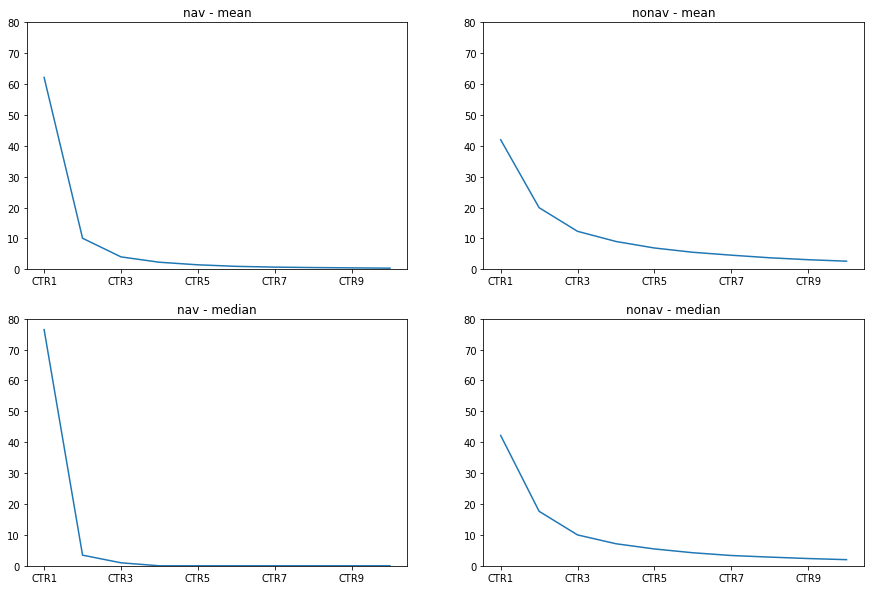

In [12]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.ylim(0, 80) 
nav.iloc[:,1:11].mean().plot().set_title('nav - mean')

plt.subplot(2, 2, 2) 
plt.ylim(0, 80) 
nonav.iloc[:,1:11].mean().plot().set_title('nonav - mean')

plt.subplot(2, 2, 3) 
plt.ylim(0, 80) 
nav.iloc[:,1:11].median().plot().set_title('nav - median')

plt.subplot(2, 2, 4)
plt.ylim(0, 80)  
nonav.iloc[:,1:11].median().plot().set_title('nonav - median')

In [13]:
def histogramm(nav, nonav):
  nav.hist(alpha = 0.5, bins = 50, color = 'red')
  nonav.hist(alpha = 0.5, bins = 50, color = 'blue')
  plt.axvline(nav.mean(), color = 'red', linestyle = 'dashed')
  plt.axvline(nonav.mean(), color = 'blue', linestyle = 'dashed')

In [14]:
def density(nav, nonav):
  nav.plot(kind='density', alpha = 0.5, color = 'red')
  nonav.plot(kind='density', alpha = 0.5, color = 'blue')
  plt.axvline(nav.median(), color = 'red', linestyle = 'dashed')
  plt.axvline(nonav.median(), color = 'blue', linestyle = 'dashed')

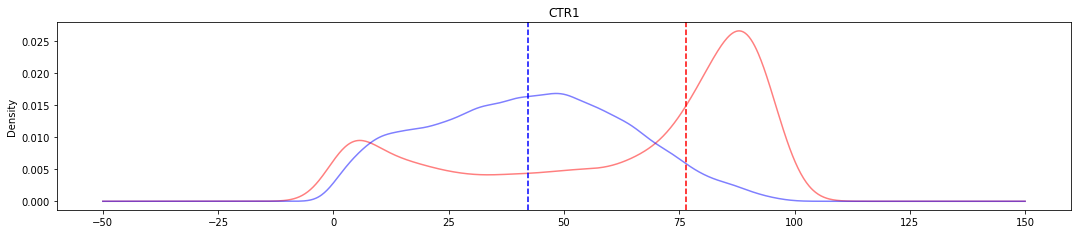

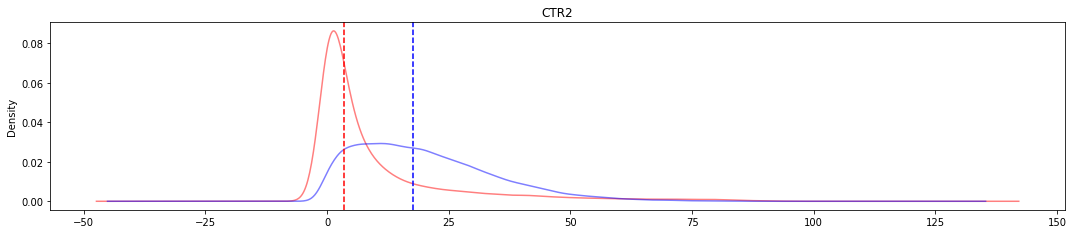

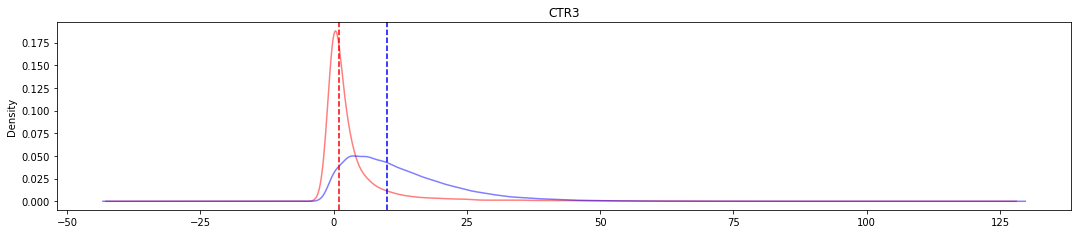

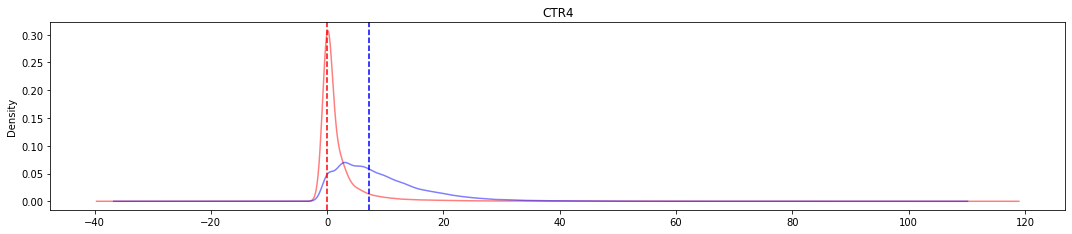

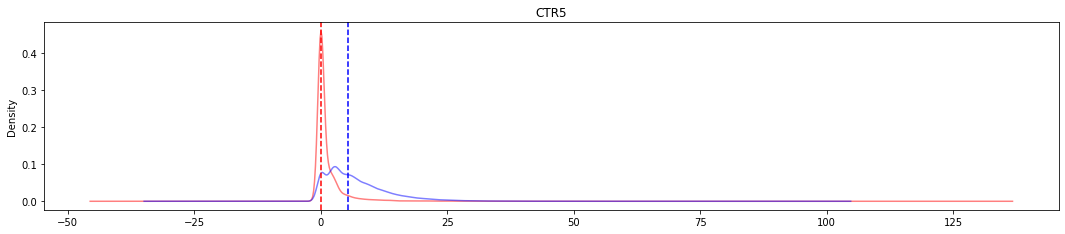

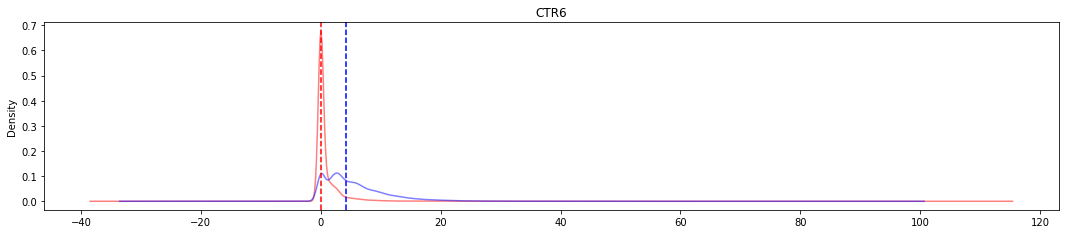

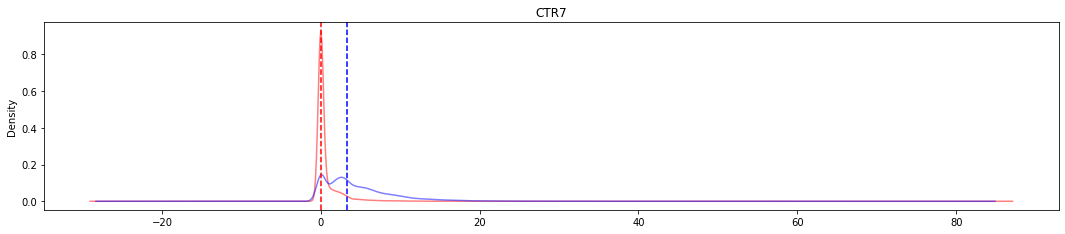

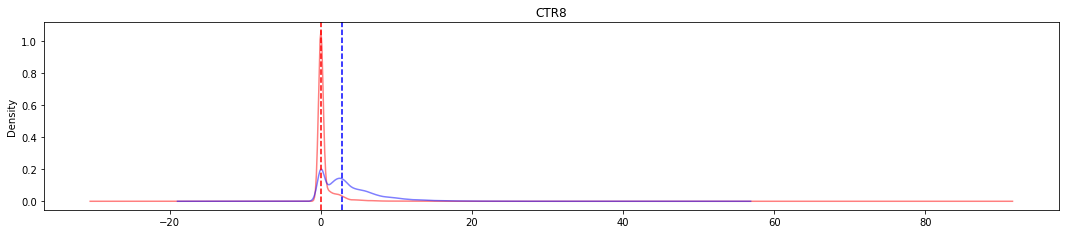

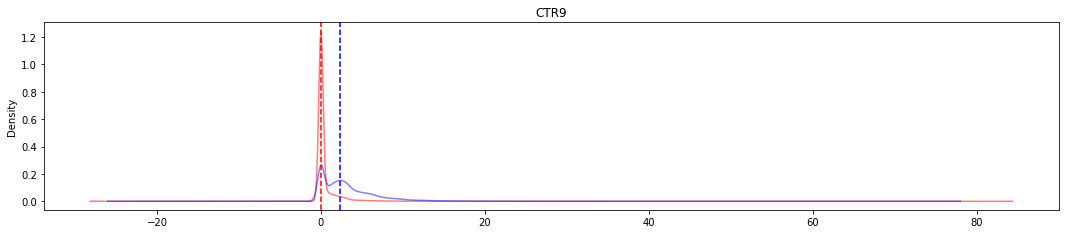

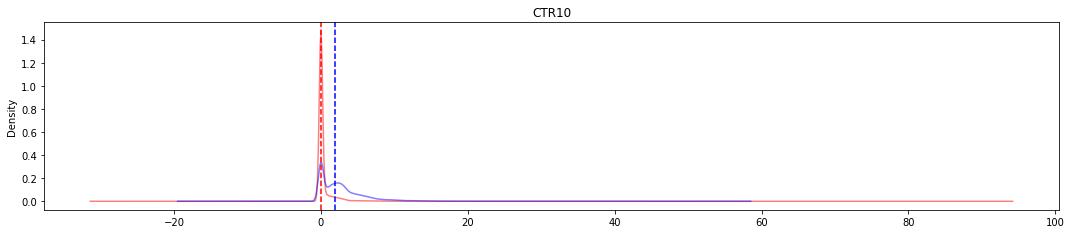

In [15]:
cnt = 1
for i in nav.columns[1:11]:
  plt.figure(figsize=(40,20))
  plt.subplot(5, 2, cnt)
  density(nav[i], nonav[i])
  plt.title(i)
  cnt += 1

Исходя из вышеприведенных графиков, можем сделать вывод о том, что у навигационных запросов кликабельность первого документа заметно более высокая, чем у ненавигационных. После второй позиции CTR очень низок.

В частности, предположим, что у навигационных запросов кликабельность первого документа больше кликабельности всех оставшихся документов из TOP-10 вместе взятых. 

Проверим классификацию запросов по этому признаку.


В качестве метрики выбран ***f1_score***

In [16]:
def check_CTR1(ctr1, ctr_sum, cnt):
  if ctr1 > cnt*ctr_sum:
    return 1
  else:
    return 0

In [17]:
temp = df.copy()
temp['rate'] = temp.apply(lambda row: check_CTR1(row[1],  row.iloc[2:11].sum(), 1), axis=1)
temp.head()

,Query,CTR1,CTR2,CTR3,CTR4,CTR5,CTR6,CTR7,CTR8,CTR9,CTR10,type,rate
0,ярмарка выходного дня,31.914894,17.021277,8.510638,10.638298,2.127660,10.638298,6.382979,10.638298,8.510638,2.127660,0,0
1,ярмарка,48.734177,6.329114,13.924051,10.759494,9.493671,6.329114,9.493671,6.329114,2.531646,1.898734,0,0
2,яндекс,5.202312,2.890173,1.156069,1.734104,0.578035,0.000000,0.578035,0.578035,0.000000,0.000000,0,0
3,янао,18.518518,11.111111,18.518518,11.111111,11.111111,7.407407,0.000000,0.000000,0.000000,3.703704,0,0
4,якутия,6.666667,6.666667,3.333333,3.333333,0.000000,3.333333,3.333333,3.333333,0.000000,0.000000,0,0


In [18]:
np.mean(temp['type']==temp['rate'])

0.7430791464124172

In [19]:
f1_score(temp['type'],temp['rate'])

0.6694356571925333

Если предположить, что у навигационных запросов CTR1 больше удвоенной суммы, то результат несколько лучше.

In [20]:
temp['rate2'] = temp.apply(lambda row: check_CTR1(row[1],  row.iloc[2:11].sum(), 2), axis=1)
np.mean(temp['type']==temp['rate2'])

0.8179088230326007

In [21]:
f1_score(temp['type'],temp['rate2'])

0.7176203504278478

In [22]:
temp['rate3'] = temp.apply(lambda row: check_CTR1(row[1],  row.iloc[2:11].sum(), 3), axis=1)
np.mean(temp['type']==temp['rate3'])

0.8274619470355287

In [23]:
f1_score(temp['type'],temp['rate3'])

0.7131400755140886

Можем заметить, что такой показатель, как CTR1 > 2*CTR_sum дает лучший результат по f1_score

В качестве признака в основную таблицу добавим отношение CTR1 к сумме CTR и отношение максимального  CTR к сумме CTR

In [24]:
def CTR1_feature(ctr1, ctr_sum):
  if ctr_sum != 0:
    return ctr1/ctr_sum
  else:
    return 0

In [25]:
df['rate_CTR1'] = df.apply(lambda row: CTR1_feature(row[1],  row.iloc[1:11].sum()), axis=1)
df['rate_CTR_MAX'] = df.apply(lambda row: CTR1_feature(row.iloc[1:11].max(),  row.iloc[1:11].sum()), axis=1)

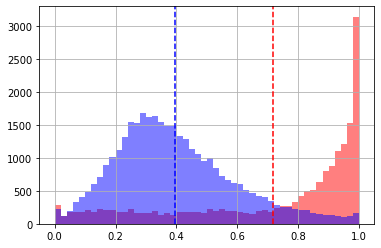

In [26]:
histogramm(df[df['type']==1]['rate_CTR1'],df[df['type']==0]['rate_CTR1'])

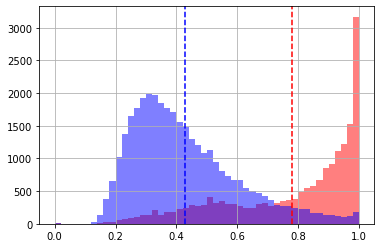

In [27]:
histogramm(df[df['type']==1]['rate_CTR_MAX'],df[df['type']==0]['rate_CTR_MAX'])

Таким образом, если в качестве порога взять среднее значение rate_CTR1 или rate_CTR_MAX навигационных запросов, можно неплохо разделить классы

In [28]:
def border_CTR(ctr, border):
  if ctr > border:
    return 1
  else:
    return 0

In [29]:
temp = df.copy()
rate_CTR1_mean = temp[temp['type']==1]['rate_CTR1'].mean()
rate_CTR_MAX_mean = temp[temp['type']==1]['rate_CTR_MAX'].mean()

In [30]:
temp['ctr1_border'] = temp.apply(lambda x: border_CTR(x['rate_CTR1'],  rate_CTR1_mean), axis=1)
f1_score(temp['type'],temp['ctr1_border'])

0.7189197390380823

In [31]:
temp['ctr_max_border'] = temp.apply(lambda x: border_CTR(x['rate_CTR_MAX'],  rate_CTR_MAX_mean), axis=1)
f1_score(temp['type'],temp['ctr_max_border'])

0.7205238799861474

Можем сделать вывод, что ***rate_CTR_MAX*** имеет лучшую разделяющую способность

## CTR_docs

Основные идеи и предположения:

1.   Документы, соответстующие многим запросам, являются "общими", то есть не совсем навигационными, поэтому при запросе стоит обратить на документы, которые являются в какой-то степени уникальными 

2. Документ, максимально соответствующий запросу, должен иметь большое число показов и высокий CTR

3. Для каждого документа можно посчитать степень его навигационности как отношение количества кликов на документ d при запросе q к суммарному количеству кликов по запросу q



В качестве новых признаков добавим:

*   ***Query_num*** - количество уникальных запросов для документа d
*   ***doc_num*** - количество документов по запросу q
*   ***doq_unique_N*** - количество документов, у которых уникальных запросов не больше N
*   ***max_CTR_quantile_Q*** - максимальное значение CTR среди документов, где число показов больше Q-го перцентиля

*   ***Nav_extent_MAX*** - максимальное отношение $np.log(Click)/np.log(Click_q)$ для запроса q

где:
*   *Click* - количество кликов на документ d в запросе q
*   *Click_q* - количество кликов по запросу q
















In [32]:
CTR_docs['Click'] = CTR_docs['Число показов']*CTR_docs['CTR документа']/100 
CTR_docs['Click_q'] = CTR_docs.groupby('Query')['Click'].transform('sum')
CTR_docs['Query_num'] = CTR_docs.groupby('ID документа')['Query'].transform('nunique')
CTR_docs['doc_num'] = CTR_docs.groupby('Query')['ID документа'].transform('count')

In [33]:
CTR_docs = CTR_docs.merge(CTR_docs[CTR_docs['Query_num'] < 7].groupby('Query')['ID документа'].count(), on= 'Query', how='left').rename(columns = {'ID документа_x': 'ID документа', 'ID документа_y': 'doc_unique_7'})
CTR_docs = CTR_docs.merge(CTR_docs[CTR_docs['Query_num'] < 5].groupby('Query')['ID документа'].count(), on= 'Query', how='left').rename(columns = {'ID документа_x': 'ID документа', 'ID документа_y': 'doc_unique_5'})
CTR_docs = CTR_docs.merge(CTR_docs[CTR_docs['Query_num'] < 3].groupby('Query')['ID документа'].count(), on= 'Query', how='left').rename(columns = {'ID документа_x': 'ID документа', 'ID документа_y': 'doc_unique_3'})

In [34]:
CTR_docs = CTR_docs.merge(CTR_docs.groupby('Query')['Число показов'].quantile(0.1), on= 'Query', how= 'left').rename(columns = {'Число показов_x': 'Число показов', 'Число показов_y': 'quantile_0.1'})
CTR_docs = CTR_docs.merge(CTR_docs[CTR_docs['Число показов'] > CTR_docs['quantile_0.1']].groupby('Query')['CTR документа'].max(), on= 'Query', how='left').rename(columns = {'CTR документа_x': 'CTR документа', 'CTR документа_y': 'max_CTR_quantile_0.1'})

CTR_docs = CTR_docs.merge(CTR_docs.groupby('Query')['Число показов'].quantile(0.25), on= 'Query', how= 'left').rename(columns = {'Число показов_x': 'Число показов', 'Число показов_y': 'quantile_0.25'})
CTR_docs = CTR_docs.merge(CTR_docs[CTR_docs['Число показов'] > CTR_docs['quantile_0.25']].groupby('Query')['CTR документа'].max(), on= 'Query', how='left').rename(columns = {'CTR документа_x': 'CTR документа', 'CTR документа_y': 'max_CTR_quantile_0.25'})

CTR_docs = CTR_docs.merge(CTR_docs.groupby('Query')['Число показов'].quantile(0.5), on= 'Query', how= 'left').rename(columns = {'Число показов_x': 'Число показов', 'Число показов_y': 'quantile_0.5'})
CTR_docs = CTR_docs.merge(CTR_docs[CTR_docs['Число показов'] > CTR_docs['quantile_0.5']].groupby('Query')['CTR документа'].max(), on= 'Query', how='left').rename(columns = {'CTR документа_x': 'CTR документа', 'CTR документа_y': 'max_CTR_quantile_0.5'})

In [35]:
CTR_docs['Nav_extent'] = np.log(CTR_docs['Click'])/np.log(CTR_docs['Click_q'])
CTR_docs['Nav_extent'] = CTR_docs['Nav_extent'].replace(np.NINF, 0)
CTR_docs['Nav_extent'] = CTR_docs['Nav_extent'].replace(np.inf, 0)
CTR_docs['Nav_extent_MAX'] = CTR_docs.groupby('Query')['Nav_extent'].transform('max')

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [36]:
CTR_docs = CTR_docs.fillna(0)

Добавим в эту таблицу метки классов

In [37]:
CTR_docs = CTR_docs.merge(df[['Query', 'type']], how='left', on='Query').drop_duplicates()

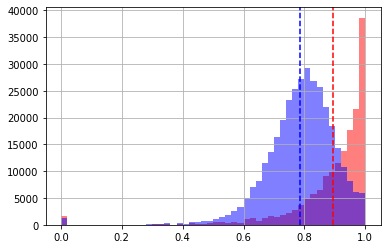

In [38]:
df1 = CTR_docs[CTR_docs['type']==1]
df2 = CTR_docs[CTR_docs['type']==0]
histogramm(df1['Nav_extent_MAX'], df2['Nav_extent_MAX'])

Визуализация признака ***Nav_extent_MAX*** дает возможность сделать вывод о более плохой разделяющей способности, чем признаки, составленные на основе таблицы CTR_position


In [39]:
temp = CTR_docs['type'].copy().dropna()
nav_mean = CTR_docs[CTR_docs['type']==1]['Nav_extent_MAX'].mean()

In [40]:
CTR_docs['nav_border'] = CTR_docs.apply(lambda x: border_CTR(x['Nav_extent_MAX'],  nav_mean), axis=1)

In [41]:
f1_score(temp,CTR_docs[~CTR_docs.index.isin(CTR_docs[CTR_docs['type'].isnull() == True].index)]['nav_border'].reset_index(drop=True))

0.6674527054563328

# Prediction и выводы

В качестве простейшей модели выбрано неглубокое решающее дерево, поскольку она [модель] легко интерпретируется 

In [42]:
df_mini = CTR_docs[['Query', 'doc_unique_7',	'doc_unique_5',	'doc_unique_3',	'max_CTR_quantile_0.1', 'max_CTR_quantile_0.25',	'max_CTR_quantile_0.5', 'Nav_extent_MAX', 'doc_num']].drop_duplicates()
df_itog = df_mini.merge(df[['Query', 'type',	'rate_CTR1',	'rate_CTR_MAX']], on= 'Query', how= 'right')
df_itog = df_itog.fillna(0)

In [43]:
X = df_itog.drop('type', axis = 1)
y = df_itog['type']

X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 23)

In [44]:
X_train = X_train1.drop('Query', axis = 1)
X_test = X_test1.drop('Query', axis = 1)

In [45]:
clf = DecisionTreeClassifier(random_state= 23, max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

f1_score(y_test,y_pred)

0.8084873673848846

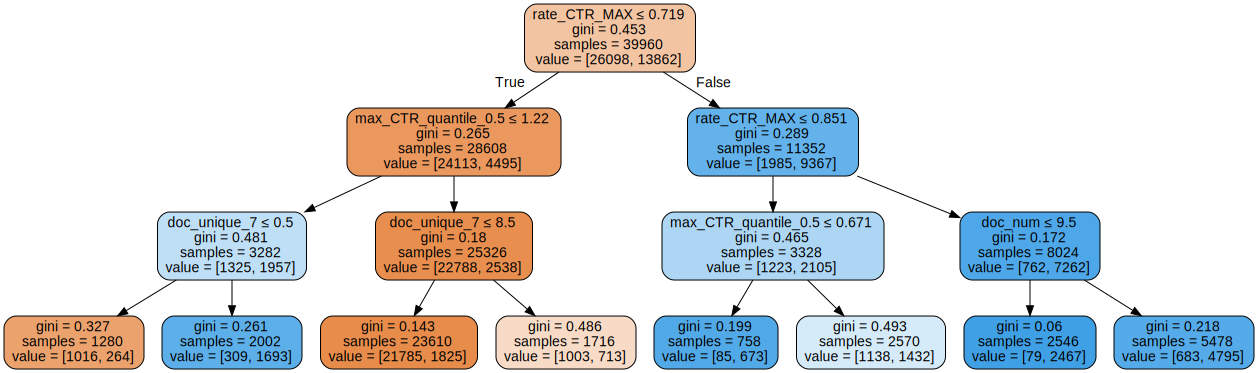

In [46]:
import graphviz

dot_data = sklearn.tree.export_graphviz(clf, 
                  feature_names=X_train.columns,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None)
graph = graphviz.Source(dot_data)
graph

Для просмотра строк, в которых мы ошибаемся

In [47]:
test = X_test1.copy()

test['type'] = y_test
test['pred'] = y_pred

In [48]:
fail_test = test[test['type'] != test['pred']]
fail_test.head(3)

,Query,doc_unique_7,doc_unique_5,doc_unique_3,max_CTR_quantile_0.1,max_CTR_quantile_0.25,max_CTR_quantile_0.5,Nav_extent_MAX,doc_num,rate_CTR1,rate_CTR_MAX,type,pred
10268,снип несущие и ограждающие конструкции,2.0,1.0,1.0,53.816794,53.816794,53.816794,0.851161,10.0,0.456221,0.456221,1,0
38889,закон об образовании в кировской области,10.0,10.0,10.0,78.512397,78.512397,78.512397,0.911283,10.0,0.368000,0.368000,1,0
35336,класс конструктивной пожарной опасности,2.0,2.0,2.0,80.000000,80.000000,80.000000,0.925687,10.0,0.807692,0.807692,0,1


In [49]:
fail_test.shape

(1751, 13)

***Выводы:***

*   Как и предполагалось, лучший признак для выявления навигационных запросов - доля максимального CTR среди CTR из ТОР-10.

*   Далее по важности идет max_CTR_quantile_0.5 - максимальное значение CTR среди документов, где число показов больше 50-го перцентиля. 

*   Затем - doc_unique_7 - количество документов, у которых уникальных запросов не больше 7.

*   Остальные признаки существенного вклада не вносят.

---


*   В таблице CTR_position имеются дублирующие запросы, которые имеют разную кликабельность, что затрудняет определение класса запроса.


*   Часть "непопаданий" связана с отсутствием у некоторых запросов (~3тыс) документов на выдаче (возможно, документы свежие и еще не загружены в базу), причем среди них есть как навигационные, так и ненавигационные.


*   Случается и наоборот, что у запроса есть документы, но "кликабельность" нулевая (что тоже может быть связано, например, со свежими документами) 



*   Схожие проблемы и просто с малыми показателями "кликабельности" запросов.

*   Таким образом, здесь присутствует проблема холодного старта (как относительно новых документов, так и относительно новых запросов).

*   К тому же, не стоит исключать неправильную разметку и наличие "мусора".

*   Таким образом, по одной лишь кликовой статистике, думаю, не удастся точно определить тип запроса. 





# Любопытство

Так как неизвестно, как определялось априори, то можно повторить действия через Tfidf и ради любопытства посмотреть, насколько мы приблизимся к таргету. Думаю, что такие задачи, как определение типа запроса, по большей мере относятся к NLP-задачам.


*   Наивная векторизация запросов без предварительной предобработки




In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression

In [51]:
# Опытным путём оказалось, что н-грамма (1, 3) - самая эффективная.
IDF = TfidfVectorizer(analyzer = "char", ngram_range=(1, 3), max_df = 0.4, min_df = 5)
x_q = IDF.fit_transform(df["Query"])

In [52]:
x_train, x_test, y_train, y_test = train_test_split(x_q, y, test_size=0.25, random_state=23)

In [57]:
LR = LogisticRegression()
LR.fit(x_train, y_train)
y_pred = LR.predict(x_test)
np.mean(y_pred == y_test)

0.9634411830943623

In [58]:
f1_score(y_test,y_pred)

0.9465129049972543

In [59]:
SGD = SGDClassifier(alpha=0.00001)
SGD.fit(x_train, y_train)
y_pred = SGD.predict(x_test)
np.mean(y_pred == y_test)


0.9721492380451918

In [60]:
f1_score(y_test,y_pred)

0.9599913728027607

То есть таким способом навигационность запроса определяется точнее. 

Вероятно, объединив два подхода, можно добиться лучшего результата.

